In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sentimentanalyser.utils.data import Path, pad_collate, grandparent_splitter
from sentimentanalyser.utils.data import parent_labeler
from sentimentanalyser.data.text import TextList

In [3]:
from sentimentanalyser.preprocessing.processor import TokenizerProcessor
from sentimentanalyser.preprocessing.processor import NuemericalizeProcessor
from sentimentanalyser.preprocessing.processor import CategoryProcessor

In [4]:
from functools import partial

In [5]:
path_imdb = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/imdb")

In [6]:
proc_tok = TokenizerProcessor()
proc_num = NuemericalizeProcessor()
proc_cat = CategoryProcessor()

In [7]:
tl_imdb = TextList.from_files(path=path_imdb, folders=['train','test'])
sd_imdb = tl_imdb.split_by_func(partial(grandparent_splitter, valid_name='test'))
ll_imdb = sd_imdb.label_by_func(parent_labeler, proc_x=[proc_tok, proc_num], proc_y=proc_cat)

In [8]:
imdb_data = ll_imdb.clas_databunchify(64)

In [9]:
from sentimentanalyser.utils.callbacks import sched_cos, combine_scheds
from sentimentanalyser.callbacks.training import CudaCallback, GradientClipping
from sentimentanalyser.callbacks.training import LRFindCustom
from sentimentanalyser.callbacks.progress import ProgressCallback
from sentimentanalyser.callbacks.scheduler import ParamSchedulerCustom
from sentimentanalyser.callbacks.stats import AvgStatsCallback
from sentimentanalyser.callbacks.recorder import RecorderCustom
from sentimentanalyser.training.trainer import Trainer

In [10]:
from sentimentanalyser.utils.dev import print_dims
from sentimentanalyser.utils.metrics import accuracy
from sentimentanalyser.utils.callbacks import create_phases, cos_1cycle_anneal

In [11]:
from sentimentanalyser.models.rnn import AttnAWDModel
from sentimentanalyser.optimizers import adam_opt

In [12]:
import torch
import torchtext
from torch import nn
from torchtext import vocab
import matplotlib.pyplot as plt

In [13]:
path_cache = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Models/WordEmbeddings')

In [14]:
glove_eng = vocab.GloVe(cache=path_cache)

In [15]:
local_vocab = proc_num.vocab

## Mixed Precision

In [16]:
import apex.fp16_utils as fp16

### Converting the model to fp16

#### don't convert Batchnorms

In [17]:
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

In [18]:
def bn_to_float(model):
    if isinstance(model, bn_types):
        model.float()
    for child in model.children():
        bn_to_float(child)
        return model

#### convert the model

In [19]:
def model_to_half(model):
    # first turn the whole model to FP16
    model = model.half()
    # Return batchnorm layers back to FP32
    return bn_to_float(model)

#### test

In [20]:
model = AttnAWDModel(local_vocab, glove_eng)

In [21]:
model = model_to_half(model)

In [22]:
def check_weights(model):
    for name, param in model.named_parameters():
        assert param.dtype == torch.float16

In [23]:
check_weights(model)

#### Apex version

In [24]:
model = AttnAWDModel(local_vocab, glove_eng)
model = fp16.convert_network(model, torch.float16)
check_weights(model)

### Creating the master copy of the parameters

In [25]:
from torch.nn.utils import parameters_to_vector

In [26]:
def get_master(model, flat_master=False):
    model_params = [param for param in model.parameters() if param.requires_grad]
    if flat_master:
        master_param = parameters_to_vector([pram.data.float() for param in model_params])
        master_param = torch.nn.Parameter(master_param, requires_grad=True)
        if master_param.grad is None:
            #initialize grads
            master_param.grad = master_param.new(*master_param.size())
        return model_params, [master_param]
    else:
        master_params = [param.clone().float().detach() for param in model_params]
        for param in master_params:
            param.requires_grad_(True)
        return model_params, master_params

#### apex version

In [27]:
model_p, master_p = get_master(model)
model_p1, master_p1 = fp16.prep_param_lists(model)

#### check

In [28]:
def same_lists(ps1, ps2):
    assert len(ps1) == len(ps2)
    for (p1, p2) in zip(ps1, ps2):
        assert p1.requires_grad == p2.requires_grad
        assert torch.allclose(p1.data.float(), p2.data.float())

In [29]:
same_lists(model_p, model_p1)
same_lists(model_p, master_p1)
same_lists(master_p, model_p1)
same_lists(master_p, master_p1)

## Backup

In [30]:
def get_master(opt, flat_master=False):
    model_pgs = [[param for param in pg if param.requires_grad] for pg in opt.param_groups]
    if flat_master:
        master_pgs = []
        for pg in model_pgs:
            mp = parameters_to_vector([param.data.float() for param in pg])
            mp = torch.nn.Parameter(mp, requires_grad=True)
            if mp.grad is None:
                mp.grad = mp.new(*mp.size())
            master_pgs.append([mp])
    else:
        master_pgs = [[param.clone().float().detach() for param in pg] for pg in model_pgs]
        for pg in master_pgs:
            for param in pg:
                param.requires_grad_(True)
    return model_pgs, master_pgs

In [31]:
def to_master_grads(model_pgs, master_pgs, flat_master:bool=False)->None:
    for (model_params, master_params) in zip(model_pgs, master_pgs):
        fp16.model_grads_to_master_grads(model_params, master_params, flat_master=flat_master)

In [32]:
def to_model_params(model_pgs, master_pgs, flat_master:bool=False)->None:
    for (model_params, master_params) in zip(model_pgs, master_pgs):
        fp16.master_params_to_model_params(model_params, master_params, flat_master=flat_master)

### Callback

In [33]:
from sentimentanalyser.callbacks.core import Callback

In [34]:
def grad_overflow(param_groups):
    for group in param_groups:
        for p in group:
            if p.grad is not None:
                s = float(p.grad.data.float().sum())
                if s == float('inf') or s == float('-inf') or s != s:
                    return True
    return False

In [115]:
class MixedPrecisionLSTM(Callback):
    _order = 99
    def __init__(self, loss_scale=512, flat_master=False, dynamic=True, max_loss_scale=2.**22, div_factor=2.,
                 scale_wait=500):
        assert torch.backends.cudnn.enabled, "Mixed precision training requires cudnn."
        self.flat_master,self.dynamic,self.max_loss_scale = flat_master,dynamic,max_loss_scale
        self.div_factor,self.scale_wait = div_factor,scale_wait
        # select default loss scale depending on if dynamic scaling is enabled
        self.loss_scale = max_loss_scale if dynamic else loss_scale
    
    def begin_fit(self):
        self.trainer.model = fp16.convert_network(self.model, dtype=torch.float16)
        self.model_pgs, self.master_pgs = get_master(self.opt, self.flat_master)
        # Changes the optimizer so that the optimization step is done in FP32.
        self.trainer.opt.param_groups = self.master_pgs # Put thoese param groups inside our runner.
        if self.dynamic:
            self.count = 0
    
    def after_pred(self):
        self.trainer.preds = self.trainer.preds.float() # Compute the loss in FP32
    
    def after_loss(self):
        if self.in_train:
            self.trainer.loss *=self.loss_scale  # Loss scaling to avoid gradient overflow
    
    def after_backward(self):
        #First, check for an overlow
        #print(self.loss_scale)
        if self.dynamic and grad_overflow(self.model_pgs):
            # Divide the loss scale by div_factor, zero the grad (after_step will be skipped)
            self.loss_scale /= self.div_factor
            self.model.zero_grad()
            return True # Skip step and zero grad
        # Copy the gradients to master and unscale
        #print('here')
        to_master_grads(self.model_pgs, self.master_pgs, self.flat_master)
        for master_params in self.master_pgs:
            for param in master_params:
                if param.grad is not None:
                    param.grad.div_(self.loss_scale)
                    #print(param.grad.mean())
        # Check if it's been long enough without over wihtout overflow
        if self.dynamic:
            self.count += 1
            if self.count == self.scale_wait:
                self.count = 0
                self.loss_scale *= self.div_factor
    
    def after_step(self):
        # Zero the gradients of the model since the optimzer is disconnected.
        self.model.zero_grad()
        # Update the params from the master to model.
        to_model_params(self.model_pgs, self.master_pgs, self.flat_master)

## Training

In [116]:
def get_basic(Model, num_layers=2):
    model = Model(proc_num.vocab, glove_eng,num_layers=num_layers)
    loss_func = nn.CrossEntropyLoss()
    opt = adam_opt()(model.parameters())
    return model, loss_func, opt

In [117]:
lr = 3e-3
pct_start = 0.5
phases = create_phases(pct_start)

In [118]:
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [124]:
cbfs = [partial(AvgStatsCallback, [accuracy]),
        partial(ParamSchedulerCustom,'lr', [sched_lr]),
        partial(ParamSchedulerCustom, 'mom', [sched_mom]),
        ProgressCallback,
        CudaCallback,
        RecorderCustom,
        MixedPrecisionLSTM
       ]

In [125]:
trainer = Trainer(imdb_data, *get_basic(AttnAWDModel), cb_funcs=cbfs)

In [126]:
trainer.fit()

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.766158,0.538160,0.813887,0.500000,01:38
1,0.805027,0.500000,0.813887,0.500000,01:38
2,0.805085,0.500000,0.813887,0.500000,01:39


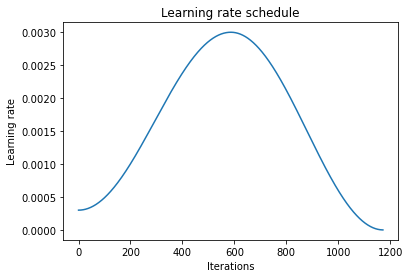

In [127]:
trainer.recorder_custom.plot_lr()